# Welcome to the [Tensor2Tensor](https://github.com/tensorflow/tensor2tensor) Colab

Tensor2Tensor, or T2T for short, is a library of deep learning models and datasets designed to make deep learning more accessible and [accelerate ML research](https://research.googleblog.com/2017/06/accelerating-deep-learning-research.html). T2T is actively used and maintained by researchers and engineers within the [Google Brain team](https://research.google.com/teams/brain/) and a community of users. This colab shows you some datasets we have in T2T, how to download and use them, some models we have, how to download pre-trained models and use them, and how to create and train your own models.

In [0]:
#@title
# Copyright 2018 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [0]:
# Install deps
!pip install -q -U tensor2tensor
!pip install -q tensorflow matplotlib


     |████████████████████████████████| 1.6MB 44.7MB/s 
     |████████████████████████████████| 655kB 46.9MB/s 
     |████████████████████████████████| 2.3MB 50.6MB/s 
     |████████████████████████████████| 317kB 53.6MB/s 
     |████████████████████████████████| 184kB 56.2MB/s 


In [0]:
# Imports we need.
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
tfe = tf.contrib.eager
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







INFO:tensorflow:Entry Point [tensor2tensor.envs.tic_tac_toe_env:TicTacToeEnv] registered with id [T2TEnv-TicTacToeEnv-v0]





# Download MNIST and inspect it

In [0]:
# A Problem is a dataset together with some fixed pre-processing.
# It could be a translation dataset with a specific tokenization,
# or an image dataset with a specific resolution.
#
# There are many problems available in Tensor2Tensor
problems.available()

['algorithmic_addition_binary40',
 'algorithmic_addition_decimal40',
 'algorithmic_cipher_shift200',
 'algorithmic_cipher_shift5',
 'algorithmic_cipher_vigenere200',
 'algorithmic_cipher_vigenere5',
 'algorithmic_identity_binary40',
 'algorithmic_identity_decimal40',
 'algorithmic_identity_vocab95_train20_eval30',
 'algorithmic_math_deepmind_all',
 'algorithmic_math_two_variables',
 'algorithmic_multiplication_binary40',
 'algorithmic_multiplication_decimal40',
 'algorithmic_reverse_binary40',
 'algorithmic_reverse_binary40_test',
 'algorithmic_reverse_decimal40',
 'algorithmic_reverse_nlplike32k',
 'algorithmic_reverse_nlplike8k',
 'algorithmic_shift_decimal40',
 'algorithmic_sort_problem',
 'audio_timit_characters_tune',
 'audio_timit_tokens8k_test',
 'audio_timit_tokens8k_tune',
 'babi_qa_concat_all_tasks_10k',
 'babi_qa_concat_all_tasks_1k',
 'babi_qa_concat_task10_10k',
 'babi_qa_concat_task10_1k',
 'babi_qa_concat_task11_10k',
 'babi_qa_concat_task11_1k',
 'babi_qa_concat_task12_

In [0]:
# Fetch the MNIST problem
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)



INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /root/t2t/tmp/train-images-idx3-ubyte.gz

100% completed

INFO:tensorflow:Successfully downloaded train-images-idx3-ubyte.gz, 9912422 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /root/t2t/tmp/train-labels-idx1-ubyte.gz
113% completed
INFO:tensorflow:Successfully downloaded train-labels-idx1-ubyte.gz, 28881 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /root/t2t/tmp/t10k-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded t10k-images-idx3-ubyte.gz, 1648877 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /root/t2t/tmp/t10k-labels-idx1-ubyte.gz
180% completed
INFO:tensorflow:Successfully downloaded t10k-labels-idx1-ubyte.gz, 4542 bytes.
INFO:tensorflow:Not downloading, file already found: /root/t2t/tmp/train-images-idx3-ub

INFO:tensorflow:Reading data files from /root/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10
Label: 1


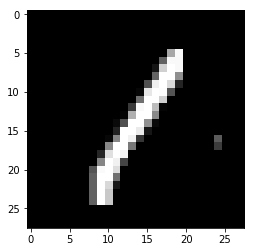

In [0]:
# Now let's see the training MNIST data as Tensors.

%matplotlib inline
mnist_example = tfe.Iterator(mnist_problem.dataset(Modes.TRAIN, data_dir)).next()
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

# Translate from English to German with a pre-trained model

In [0]:
# Fetch the problem
ende_problem = problems.problem("translate_ende_wmt32k")

# Copy the vocab file locally so we can encode inputs and decode model outputs
# All vocabs are stored on GCS
vocab_name = "vocab.translate_ende_wmt32k.32768.subwords"
vocab_file = os.path.join(gs_data_dir, vocab_name)
!gsutil cp {vocab_file} {data_dir}

# Get the encoders from the problem
encoders = ende_problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

Copying gs://tensor2tensor-data/vocab.translate_ende_wmt32k.32768.subwords...
/ [1 files][313.8 KiB/313.8 KiB]                                                
Operation completed over 1 objects/313.8 KiB.                                    


In [0]:
# # Generate and view the data
# # This cell is commented out because WMT data generation can take hours

# ende_problem.generate_data(data_dir, tmp_dir)
# example = tfe.Iterator(ende_problem.dataset(Modes.TRAIN, data_dir)).next()
# inputs = [int(x) for x in example["inputs"].numpy()] # Cast to ints.
# targets = [int(x) for x in example["targets"].numpy()] # Cast to ints.



# # Example inputs as int-tensor.
# print("Inputs, encoded:")
# print(inputs)
# print("Inputs, decoded:")
# # Example inputs as a sentence.
# print(decode(inputs))
# # Example targets as int-tensor.
# print("Targets, encoded:")
# print(targets)
# # Example targets as a sentence.
# print("Targets, decoded:")
# print(decode(targets))

In [0]:
# There are many models available in Tensor2Tensor
registry.list_models()

['aligned',
 'attention_lm',
 'attention_lm_moe',
 'autoencoder_autoregressive',
 'autoencoder_basic',
 'autoencoder_basic_discrete',
 'autoencoder_dual_discrete',
 'autoencoder_ordered_discrete',
 'autoencoder_residual',
 'autoencoder_residual_discrete',
 'autoencoder_residual_vae',
 'autoencoder_stacked',
 'basic_fc_relu',
 'byte_net',
 'cycle_gan',
 'dense_bitwise_categorical_policy',
 'diagonal_neural_gpu',
 'distillation',
 'evolved_transformer',
 'feed_forward_categorical_policy',
 'feed_forward_cnn_small_categorical_policy',
 'feed_forward_cnn_small_categorical_policy_new',
 'gene_expression_conv',
 'glow',
 'imagetransformer',
 'imagetransformer2d',
 'imagetransformer_moe',
 'img2img_transformer',
 'img2img_transformer_block_parallel',
 'lstm_encoder',
 'lstm_seq2seq',
 'lstm_seq2seq_attention',
 'lstm_seq2seq_attention_bidirectional_encoder',
 'lstm_seq2seq_bidirectional_encoder',
 'mtf_bitransformer',
 'mtf_image_transformer',
 'mtf_res_net',
 'mtf_transformer',
 'mtf_unitran

In [0]:
# Create hparams and the model
model_name = "transformer"
hparams_set = "transformer_base"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="translate_ende_wmt32k")

# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
translate_model = registry.model(model_name)(hparams, Modes.EVAL)

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.label_smoothing to 0.0
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0




In [0]:
# Copy the pretrained checkpoint locally
ckpt_name = "transformer_ende_test"
gs_ckpt = os.path.join(gs_ckpt_dir, ckpt_name)
!gsutil -q cp -R {gs_ckpt} {checkpoint_dir}
ckpt_path = tf.train.latest_checkpoint(os.path.join(checkpoint_dir, ckpt_name))
ckpt_path

'/root/t2t/checkpoints/transformer_ende_test/model.ckpt-1421000'

In [0]:
# Restore and translate!
def translate(inputs):
  encoded_inputs = encode(inputs)
  with tfe.restore_variables_on_create(ckpt_path):
    model_output = translate_model.infer(encoded_inputs)["outputs"]
  return decode(model_output)

inputs = "The animal didn't cross the street because it was too tired"
outputs = translate(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)


INFO:tensorflow:Greedy Decoding
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.

Instructions for updating:
Use `tf.cast` instead.
Inputs: The animal didn't cross the street because it was too tired
Outputs: Das Tier überquerte die Straße nicht, weil es zu müde war, weil es zu müde war.


## Attention Viz Utils

In [0]:
from tensor2tensor.visualization import attention
from tensor2tensor.data_generators import text_encoder

SIZE = 35

def encode_eval(input_str, output_str):
  inputs = tf.reshape(encoders["inputs"].encode(input_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  outputs = tf.reshape(encoders["inputs"].encode(output_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  return {"inputs": inputs, "targets": outputs}

def get_att_mats():
  enc_atts = []
  dec_atts = []
  encdec_atts = []

  for i in range(hparams.num_hidden_layers):
    enc_att = translate_model.attention_weights[
      "transformer/body/encoder/layer_%i/self_attention/multihead_attention/dot_product_attention" % i][0]
    dec_att = translate_model.attention_weights[
      "transformer/body/decoder/layer_%i/self_attention/multihead_attention/dot_product_attention" % i][0]
    encdec_att = translate_model.attention_weights[
      "transformer/body/decoder/layer_%i/encdec_attention/multihead_attention/dot_product_attention" % i][0]
    enc_atts.append(resize(enc_att))
    dec_atts.append(resize(dec_att))
    encdec_atts.append(resize(encdec_att))
  return enc_atts, dec_atts, encdec_atts

def resize(np_mat):
  # Sum across heads
  np_mat = np_mat[:, :SIZE, :SIZE]
  row_sums = np.sum(np_mat, axis=0)
  # Normalize
  layer_mat = np_mat / row_sums[np.newaxis, :]
  lsh = layer_mat.shape
  # Add extra dim for viz code to work.
  layer_mat = np.reshape(layer_mat, (1, lsh[0], lsh[1], lsh[2]))
  return layer_mat

def to_tokens(ids):
  ids = np.squeeze(ids)
  subtokenizer = hparams.problem_hparams.vocabulary['targets']
  tokens = []
  for _id in ids:
    if _id == 0:
      tokens.append('<PAD>')
    elif _id == 1:
      tokens.append('<EOS>')
    elif _id == -1:
      tokens.append('<NULL>')
    else:
        tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
  return tokens

In [0]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

## Display Attention

In [0]:
# Convert inputs and outputs to subwords
inp_text = to_tokens(encoders["inputs"].encode(inputs))
out_text = to_tokens(encoders["inputs"].encode(outputs))

# Run eval to collect attention weights
example = encode_eval(inputs, outputs)
with tfe.restore_variables_on_create(tf.train.latest_checkpoint(checkpoint_dir)):
  translate_model.set_mode(Modes.EVAL)
  translate_model(example)
# Get normalized attention weights for each layer
enc_atts, dec_atts, encdec_atts = get_att_mats()

call_html()
attention.show(inp_text, out_text, enc_atts, dec_atts, encdec_atts)

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_33288_512.bottom
INFO:tensorflow:Transforming feature 'targets' with symbol_modality_33288_512.targets_bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Transforming body output with symbol_modality_33288_512.top


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a custom model on MNIST

In [0]:
# Create your own model

class MySimpleModel(t2t_model.T2TModel):

  def body(self, features):
    inputs = features["inputs"]
    filters = self.hparams.hidden_size
    h1 = tf.layers.conv2d(inputs, filters,
                          kernel_size=(5, 5), strides=(2, 2))
    h2 = tf.layers.conv2d(tf.nn.relu(h1), filters,
                          kernel_size=(5, 5), strides=(2, 2))
    return tf.layers.conv2d(tf.nn.relu(h2), filters,
                            kernel_size=(3, 3))

hparams = trainer_lib.create_hparams("basic_1", data_dir=data_dir, problem_name="image_mnist")
hparams.hidden_size = 64
model = MySimpleModel(hparams, Modes.TRAIN)

INFO:tensorflow:Setting T2TModel mode to 'train'


In [0]:
# Prepare for the training loop

# In Eager mode, opt.minimize must be passed a loss function wrapped with
# implicit_value_and_gradients
@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

# Setup the training data
BATCH_SIZE = 128
mnist_train_dataset = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_train_dataset = mnist_train_dataset.repeat(None).batch(BATCH_SIZE)

optimizer = tf.train.AdamOptimizer()

INFO:tensorflow:Reading data files from /root/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10


In [0]:
# Train
NUM_STEPS = 500

for count, example in enumerate(tfe.Iterator(mnist_train_dataset)):
  example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 50 == 0:
    print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
    break

INFO:tensorflow:Transforming feature 'inputs' with image_modality.bottom
INFO:tensorflow:Transforming feature 'targets' with class_label_modality_10_64.targets_bottom
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
INFO:tensorflow:Transforming body output with class_label_modality_10_64.top
Instructions for updating:
Use keras.layers.dense instead.
Step: 0, Loss: 7.233
Step: 50, Loss: 1.123
Step: 100, Loss: 0.804
Step: 150, Loss: 0.599
Step: 200, Loss: 0.327
Step: 250, Loss: 0.598
Step: 300, Loss: 0.357
Step: 350, Loss: 0.466
Step: 400, Loss: 0.343
Step: 450, Loss: 0.341
Step: 500, Loss: 0.349


In [0]:
model.set_mode(Modes.EVAL)
mnist_eval_dataset = mnist_problem.dataset(Modes.EVAL, data_dir)

# Create eval metric accumulators for accuracy (ACC) and accuracy in
# top 5 (ACC_TOP5)
metrics_accum, metrics_result = metrics.create_eager_metrics(
    [metrics.Metrics.ACC, metrics.Metrics.ACC_TOP5])

for count, example in enumerate(tfe.Iterator(mnist_eval_dataset)):
  if count >= 200:
    break

  # Make the inputs and targets 4D
  example["inputs"] = tf.reshape(example["inputs"], [1, 28, 28, 1])
  example["targets"] = tf.reshape(example["targets"], [1, 1, 1, 1])

  # Call the model
  predictions, _ = model(example)

  # Compute and accumulate metrics
  metrics_accum(predictions, example["targets"])

# Print out the averaged metric values on the eval data
for name, val in metrics_result().items():
  print("%s: %.2f" % (name, val))

INFO:tensorflow:Reading data files from /root/t2t/data/image_mnist-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
accuracy: 0.98
accuracy_top5: 1.00
